# Topic Modelling (LDA) over entire documents - TED Talks

This notebook contain a workflow of a first exploration with LDA method implemented in *gensim* package. We store in a list  each  all the 61 `*.txt` files from Google Drive folder of Task 1, then we clean the corpus and passed it to ``.

## Packages used

In [131]:
# Importing modules
import pandas as pd
import os
from pathlib import Path
os.chdir('..')
import glob
import unidecode
import pathlib

# Load the library with the CountVectorizer method
import nltk
from nltk import word_tokenize
from nltk.data import load
from nltk.stem import SnowballStemmer
from string import punctuation
import es_core_news_sm
import unidecode
import string

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [132]:
## Download stopwords if you do not have it
# nltk.download()

In [133]:
from nltk.corpus import stopwords
# stop_words = stopwords.words('spanish')
stop_words = spacy.lang.es.stop_words.STOP_WORDS

## Set the path

Set your workspace in the right location:

    `%cd Your_paht/wrilatinamerica`

Type your path in the next cell.

In [134]:
%cd C:\Users\dcalle.MATONE\Documents\GitHub\wrilatinamerica
%pwd

C:\Users\dcalle.MATONE\Documents\GitHub\wrilatinamerica


'C:\\Users\\dcalle.MATONE\\Documents\\GitHub\\wrilatinamerica'

## Load the data

We navigated through folders to locate the preprocessed `*.txt` files. `documents` is a list with all the documents, labebeld with the corresponding country and file name.

In [135]:
TED_talks_all = pd.read_csv('src/data/docs/ted_talks_es.csv')
TED_talks = TED_talks_all.sample(frac=0.01, replace=True, random_state=1)
print(TED_talks.columns)
TED_content = TED_talks.transcript.tolist()
print(TED_content[0][:500])
print(TED_talks.shape)
TED_talks.head(2)

Index(['talk_id', 'title', 'speaker_1', 'all_speakers', 'occupations',
       'about_speakers', 'views', 'recorded_date', 'published_date', 'event',
       'native_lang', 'available_lang', 'comments', 'duration', 'topics',
       'related_talks', 'url', 'description', 'transcript'],
      dtype='object')
Casi todos formamos parte de una comunidad en el mundo, grande o pequeña. Y todas estas comunidades tienen necesidades muy parecidas. Necesitan luz, necesitan calor, necesitan refrigeración. La gente no funciona demasiado bien si hace mucho calor o mucho frío. Necesitan cultivar o producir alimentos, y distribuirlos y almacenarlos de forma segura. Los desechos deben recolectarse, eliminarse y procesarse. En una comunidad, la gente necesita trasladarse de un lugar a otro de la forma más rápida po
(39, 19)


,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,native_lang,available_lang,comments,duration,topics,related_talks,url,description,transcript
1061,1324,El torio: un combustible nuclear alternativo,Kirk Sorensen,{0: 'Kirk Sorensen'},"{0: ['engineer', 'nuclear technologist']}",{0: 'Kirk Sorensen stumbled across thorium whi...,606386,2011-04-01,2012-01-14,TEDxYYC,en,"['ar', 'da', 'en', 'es', 'fa', 'fr', 'hu', 'id...",341.0,599,"['TEDx', 'alternative energy', 'nuclear energy...","{862: 'Planning for the end of oil', 718: ""Fus...",https://www.ted.com/talks/kirk_sorensen_thoriu...,Kirk Sorensen nos muestra el reactor de torio ...,Casi todos formamos parte de una comunidad en ...
235,279,Chris Jordan muestra unas sorprendentes estadí...,Chris Jordan,{0: 'Chris Jordan'},{0: ['artist']},{0: 'Chris Jordan runs the numbers on modern A...,1930761,2008-02-02,2008-06-15,TED2008,en,"['ar', 'bg', 'de', 'el', 'en', 'es', 'et', 'fa...",230.0,674,"['art', 'beauty', 'business', 'culture', 'phot...",{56: 'My wish: Manufactured landscapes and gre...,https://www.ted.com/talks/chris_jordan_turning...,El artista Chris Jordan nos muestra una perspe...,Mi trabajo es acerca de la comportamientos que...


In [136]:
countries = ['mexico','peru','chile','guatemala', 'el salvador']
docs_path = Path("src/data/docs")

documents = list()
big_files = 0

for country in countries:

    txt_path = docs_path / country.title()
    files = os.listdir(txt_path)
    files = [file for file in files if '.txt' in file]
    
    for elem in files:
        if type(elem) == str:
            file_name = elem.split('/')[-1].split('.')[0]
        else: continue 
        open_path = os.path.join(txt_path, file_name + ".txt")
        print(open_path)
        
        try:
            with open(open_path, 'rb') as text:
                decoded = text.read()
                decoded = decoded.decode('UTF-8').replace('\n', ' ')
                
            # Avoiding too large texts (for processing whole documents)
            if len(decoded)>1000000:
                text.close
                big_files += 1
            else:
                documents.append((country.title(),file_name,decoded))
                text.close
        except: 
            print("This file must be included locally ", file_name)
            continue

src\data\docs\Mexico\CONAFOR_ plan 2025_preprocessed.txt
src\data\docs\Mexico\Folleto_Sembrando_Vida_-_Espa_ol (1)_preprocessed.txt
src\data\docs\Mexico\Lineamientos_de_Operaci_n_del_Programa_Sembrando_Vida_preprocessed.txt
src\data\docs\Mexico\Mexico_LGDFS_050618_preprocessed.txt
src\data\docs\Mexico\Normasde Operacion CONAFOR_preprocessed.txt
src\data\docs\Mexico\reglas de operacion DOF - Diario Oficial de la Federación_preprocessed.txt
src\data\docs\Mexico\SembrandovidaReportefeb2019Febrero-1_preprocessed.txt
src\data\docs\Peru\007-2015_preprocessed.txt
src\data\docs\Peru\1633_preprocessed.txt
src\data\docs\Peru\19-politica_nacional_forestal_y_de_fauna_silvestre_-_edicion_de_bolsillo_2017_-_serfor_preprocessed.txt
src\data\docs\Peru\2061_preprocessed.txt
src\data\docs\Peru\2063_preprocessed.txt
src\data\docs\Peru\2065_preprocessed.txt
src\data\docs\Peru\3119_preprocessed.txt
src\data\docs\Peru\aportes_leg_cc_preprocessed.txt
src\data\docs\Peru\ley_n_preprocessed.txt
src\data\docs\Pe

## Preprocessing

In the first place, we perform tokenization with `sent_to_words` function over the corpus. We then implemented some functions:

0. `sent_to_words`: function for tokenization.

1. `make_bigrams`/`make_trigrams`: They build unigrams/bigrams/trigrams combinations for not miss useful expressions not covered by simple unigrams.

3. `lemmatization`: a *spaCy* function that lemmatize our tokens.

In [137]:
all_docs = [k for _,_,k in documents]
all_docs.extend(TED_content)
all_docs[-1][:100]
len(all_docs)

97

In [138]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(all_docs))

# Some tokens of the first document
print(data_words[0][:10])

['indice', 'lista', 'cuadros', 'figurasiv', 'lista', 'anexosv', 'acronimos', 'abreviaturasv', 'presentacion', 'introduccion']


In [139]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=2, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [140]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]][:100])

['indice', 'lista', 'cuadros', 'figurasiv', 'lista', 'anexosv', 'acronimos', 'abreviaturasv', 'presentacion', 'introduccion', 'antecedentes', 'organizacion', 'proyecto', 'objetivo', 'programa', 'estrategico', 'forestal', 'mexico', 'proceso', 'elaboracion', 'plan', 'diagnostico', 'recursos', 'naturales', 'marco', 'referencia', 'degradacion', 'recursos', 'manejo', 'forestal', 'plantaciones', 'forestales', 'germoplasma', 'aprovechamiento', 'industria', 'forestal', 'bioenergia', 'servicios', 'ambientales', 'recursos', 'maderables', 'biodiversidad', 'mecanismos', 'financieros', 'marco', 'institucional', 'servicios', 'tecnicos', 'inspeccion_vigilancia', 'sistema', 'nacional', 'informacion', 'forestal', 'inventario', 'nacional', 'forestal', 'educacion', 'capacitacion', 'investigacion', 'cultura', 'forestal', 'marco_juridico', 'fortalezas_debilidades', 'comparativas', 'sector', 'forestal', 'maderable', 'implicaciones', 'sociales', 'objetivos', 'del', 'desarrollo', 'forestal', 'sustentable', 'o

In [141]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
#-----------------------------------------------------------------------------------------------------------
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Now, let's run the preprocessing.

In [142]:
# !python -m spacy download es_core_news_md

# If fails, please, uncomment the preceeding line
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])

In [143]:
added_stopwords = ["ley","casar", "nacion", "republica", "decreto", "pagina", "resolución", "resolucion", "decir", "siguiente", "terminos", "presidente", 
 "decretar", "ministro", "respectivo", "fecho", "caracter", "ano", "secretario", "asamblea", "senado", "deberan", "anexo", "informacion", "enmienda",
 "deberian", "signatario", "inclusive"]

for w in added_stopwords:
    stop_words.add(w)
    
for w in stopwords.words('spanish'):
    stop_words.add(w)

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [144]:
print(data_lemmatized[0][:5])

['cuadro', 'listo', 'anexosv', 'acronimos', 'objetivar']


# Model fitting

Then, we crated the bag of words. It is an input needed for the model.

In [145]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [146]:
# View
print(corpus[0][:10])

[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 10), (7, 13), (8, 1), (9, 1)]


And we search for the better value of `num_topics`. We used the following functions:

4. `compute_coherence values`: this function computes models with different number of topics and return their coherence so that a best model can be defined.

5. `format_topic_paragraphs`: it creates a dataframe that relates the most relevant topic to each document, its title and the corresponding country.

In [147]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values
#-----------------------------------------------------------------------------------------------------------
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
#         try:
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
#         except: print(row)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, topic_info in enumerate(row): #(topic_num, prop_topic)
            topic_num = topic_info[0]
            prop_topic = topic_info[1]
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In the following cell, the search is performed.

In [148]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                                        texts=data_lemmatized, start=20, 
                                                        limit=80, step=5)

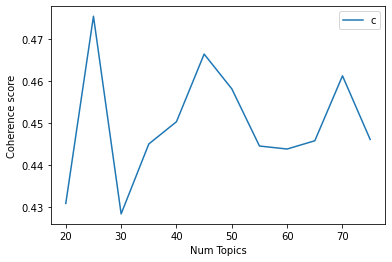

In [149]:
# Show graph
limit=80; start=20; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [150]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 20  has Coherence Value of 0.4308
Num Topics = 25  has Coherence Value of 0.4755
Num Topics = 30  has Coherence Value of 0.4283
Num Topics = 35  has Coherence Value of 0.445
Num Topics = 40  has Coherence Value of 0.4503
Num Topics = 45  has Coherence Value of 0.4664
Num Topics = 50  has Coherence Value of 0.4581
Num Topics = 55  has Coherence Value of 0.4445
Num Topics = 60  has Coherence Value of 0.4438
Num Topics = 65  has Coherence Value of 0.4457
Num Topics = 70  has Coherence Value of 0.4612
Num Topics = 75  has Coherence Value of 0.446


In [153]:
import pickle
# save the model to disk
optimal_model = model_list[5]
filename = r'par_TED_LDA_45_topic_model.sav'
pickle.dump(optimal_model, open(filename, 'wb'))

# Outputs

So, we chose the model with highst coherence

In [124]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)

and exported the output:

In [121]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=all_docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()

# Adding country and name of document
ted_list = TED_talks.title.tolist()
tmp_docs = [j for _,j,_ in documents]
tmp_country = [i for i,_,_ in documents]

for elem in ted_list:
    tmp_docs.append(elem)
    tmp_country.append("TED")

doc_names = pd.Series(tmp_docs)
doc_country = pd.Series(tmp_country)
df_dominant_topic = pd.concat([df_dominant_topic, doc_names, doc_country], axis = 1)

# doc_names = TED_talks.title.tolist()
# df_dominant_topic = pd.concat([df_dominant_topic, doc_names], axis = 1)

df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 
                             'Document_name','Country']

# Show
df_dominant_topic.to_csv('src/models/LDA/entire_TED_topics.csv')
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Document_name,Country
0,0,24.0,0.6799,"aguar, desarrollar, plantar, ciudad, sistema, ...",ÍNDICE\r \r Lista cuadros figurasiv\r Lista an...,CONAFOR_ plan 2025_preprocessed,Mexico
1,1,26.0,0.4270,"personar, ser, decir, hacer, mas, mujer, ano, ...",EN EL CORAZÓN DE NUESTRA TIERRA\r SEMBRAREMOS ...,Folleto_Sembrando_Vida_-_Espa_ol (1)_preprocessed,Mexico
2,2,24.0,0.4920,"aguar, desarrollar, plantar, ciudad, sistema, ...",DOF 24 01 2019\r \r ACUERDO emiten Lineamiento...,Lineamientos_de_Operaci_n_del_Programa_Sembran...,Mexico
3,3,24.0,0.6838,"aguar, desarrollar, plantar, ciudad, sistema, ...",LEY GENERAL DE DESARROLLO FORESTAL SUSTENTABLE...,Mexico_LGDFS_050618_preprocessed,Mexico
4,4,24.0,0.5266,"aguar, desarrollar, plantar, ciudad, sistema, ...",Jueves 16 enero 2020\r \r DIARIO OFICIAL\r \r ...,Normasde Operacion CONAFOR_preprocessed,Mexico
5,5,24.0,0.4888,"aguar, desarrollar, plantar, ciudad, sistema, ...",4 27 2020\r \r DOF Diario Oficial Federación\r...,reglas de operacion DOF - Diario Oficial de la...,Mexico
6,6,26.0,0.5323,"personar, ser, decir, hacer, mas, mujer, ano, ...",Viernes 1 febrero 2019\r \r “ Levántate sacúde...,SembrandovidaReportefeb2019Febrero-1_preprocessed,Mexico
7,7,14.0,0.4562,"mas, hacer, poder, ver, solo, ser, ano, formar...",\r \r \r \r \r Resolución Directoral\r Nº 007 ...,007-2015_preprocessed,Peru
8,8,24.0,0.7257,"aguar, desarrollar, plantar, ciudad, sistema, ...",POLITICA NACIONAL\r DEL\r AMBIENTE\r \r Decret...,1633_preprocessed,Peru
9,9,24.0,0.6885,"aguar, desarrollar, plantar, ciudad, sistema, ...",POLÍTICA NACIONAL\r FORESTAL Y DE\r FAUNA SILV...,19-politica_nacional_forestal_y_de_fauna_silve...,Peru


In [127]:
optimal_model.show_topics(25)

[(0,
  '0.016*"aguar" + 0.010*"empresa" + 0.010*"desarrollar" + 0.008*"sistema" + 0.008*"ano" + 0.008*"plantar" + 0.007*"ciudad" + 0.006*"millón" + 0.006*"riesgo" + 0.006*"aumentar"'),
 (1,
  '0.000*"seguira_siendo" + 0.000*"multirracial" + 0.000*"cap_crunch" + 0.000*"ayudeme" + 0.000*"vers" + 0.000*"sonambulo" + 0.000*"darmouth" + 0.000*"recortarse" + 0.000*"indonesia_brasil" + 0.000*"irrespetuoso"'),
 (2,
  '0.015*"escandinavo" + 0.010*"interceptar" + 0.001*"dinamismo" + 0.000*"remo" + 0.000*"vikingo" + 0.000*"druida" + 0.000*"harapo" + 0.000*"clavo" + 0.000*"imperio_romano" + 0.000*"movilidad_social"'),
 (3,
  '0.000*"seguira_siendo" + 0.000*"multirracial" + 0.000*"cap_crunch" + 0.000*"ayudeme" + 0.000*"vers" + 0.000*"sonambulo" + 0.000*"darmouth" + 0.000*"recortarse" + 0.000*"indonesia_brasil" + 0.000*"irrespetuoso"'),
 (4,
  '0.000*"seguira_siendo" + 0.000*"multirracial" + 0.000*"cap_crunch" + 0.000*"ayudeme" + 0.000*"vers" + 0.000*"sonambulo" + 0.000*"darmouth" + 0.000*"recortars

And finally, we implemented a visualization:

In [125]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
# pldavis_path = "src/models/LDA/visualization_LDA_entire_documents"
# pyLDAvis.save_html(vis, pldavis_path + '.html')
vis

TypeError: Object of type complex is not JSON serializable

PreparedData(topic_coordinates=                        x                   y  topics  cluster       Freq
topic                                                                    
14    -0.426324+0.000000j -0.220605+0.000000j       1        1  82.576515
0     -0.485374+0.000000j -0.089500+0.000000j       2        1  12.876002
24    -0.395176+0.000000j  0.341917+0.000000j       3        1   4.374382
16     0.043909+0.000000j  0.028670+0.000000j       4        1   0.144357
13     0.063111+0.000000j -0.001681+0.000000j       5        1   0.010233
11     0.061526+0.000000j -0.002364+0.000000j       6        1   0.003697
2      0.061250+0.000000j -0.002472+0.000000j       7        1   0.003571
6      0.060759+0.000000j -0.002661+0.000000j       8        1   0.002793
9      0.060220+0.000000j -0.002861+0.000000j       9        1   0.001260
5      0.059756+0.000000j -0.003028+0.000000j      10        1   0.000454
4      0.059756+0.000000j -0.003028+0.000000j      11        1   0.000450
8      